In [2]:
%matplotlib

Using matplotlib backend: MacOSX


In [3]:
import os
import sys
from astropy.io import fits, ascii
from astropy import table
from astropy.cosmology import FlatLambdaCDM
from astropy.wcs import WCS

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from numpy import ma
import pandas as pd
from scipy import integrate
from scipy import interpolate

In [4]:
from importlib import reload

In [5]:
import romanz

In [9]:
reload(romanz)

<module 'romanz' from '/Users/rodney/Dropbox/src/roman-sn-redshifts/romanz/romanz.py'>

In [10]:
romanz_sim = romanz.CatalogBasedRedshiftSim()
romanz_sim.read_galaxy_catalog(_TEST_GALCAT_)
#hostlib = romanz.SNANAHostLib('data/Akari_Hosts_subset_SNR_v7.HOSTLIB')

In [11]:
romanz_sim.galaxies[:3]

pind,ra,dec,id,u_LSST,du,g_LSST,dg,r_LSST,dr,i_LSST,di,z_LSST,dz,y_WFIRST,dy,j_WFIRST,dj,h_WFIRST,dh,F184W_WFIRST,df184w,k,dk,redshift,F160Wmag,fwhm,logmass,logsfr,SPECBASIS00,SPECBASIS01,SPECBASIS02,SPECBASIS03,SPECBASIS04,SPECBASIS05,SPECBASIS06,SPECBASIS07,SPECBASIS08,SPECBASIS09,SPECBASIS10,SPECBASIS11,SPECBASIS12
int64,float64,float64,bytes10,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,53.1016846,-27.9584789,gs3,99.0,25.09782,99.0,27.66925,99.0,24.011257,99.0,30.337896,21.958466,0.027543243,21.812433,0.5,21.576134,0.0099698035,21.417574,0.011421934,21.37767,0.011421934,21.455383,0.019616662,0.264,21.37,15.85,8.890420913696289,-0.7488535283548492,535097866255041.5,0.0,0.0,1479060201866843.0,0.0,0.0,3396420628009332.5,0.0,0.0,0.0,556237586005436.9,56933195918765.11,250930680163412.66
2,53.1022797,-27.9586506,gs4,99.0,27.575985,99.0,28.607008,99.0,26.222107,99.0,30.451311,24.438059,0.33416545,24.37078,0.5,24.272863,0.1644557,24.113474,0.2648947,23.967882,0.2648947,23.817171,0.08241054,0.63,24.07,9.84,8.786041259765625,-0.9800616143790363,0.0,743947795952009.0,680049854669785.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,53.0961494,-27.957592,gs7,24.438318,0.045711488,23.888222,0.048546124,23.136438,0.02018684,22.465458,0.021632472,22.195549,0.018573873,22.005968,0.5,21.735071,0.010468044,21.541769,0.015525257,21.380089,0.015525257,21.229603,0.009496524,0.684,21.48,33.95,9.761927604675293,0.9860848269528345,308674474148642.3,501718569690134.3,2395665206065732.5,0.0,92858020496689.36,0.0,1135327933409813.0,0.0,0.0,374695245968551.7,0.0,1810690679172474.5,138199673371103.03


In [90]:
hostlib.galdatatable[:3]

GALID,RA_GAL,DEC_GAL,ZTRUE,n0_Sersic,a0_Sersic,b0_Sersic,w0_Sersic,n1_Sersic,a1_Sersic,b1_Sersic,w1_Sersic,a_rot,y_obs,j_obs,h_obs,f_obs,pind,logsfr,logmass,logssfr,SPECBASIS00,SPECBASIS01,SPECBASIS02,SPECBASIS03,SPECBASIS04,SPECBASIS05,SPECBASIS06,SPECBASIS07,SPECBASIS08,SPECBASIS09,SPECBASIS10,SPECBASIS11,SPECBASIS12
int64,float64,float64,float64,int64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
4999,71.43116,-53.43989,1.266,1,0.1485,0.1356,0.6068,4,0.1485,0.1356,0.3932,330.385,23.1714,23.1103,23.0053,22.9329,27016,1.086,9.041,-7.956,74907060000000.0,107945700000000.0,957314600000000.0,0.0,0.0,0.0,0.0,0.0,0.0,242294400000000.0,0.0,394816000000000.0,0.0
5000,70.98357,-52.39175,1.342,1,0.6319,0.4432,0.6222,4,0.6319,0.4432,0.3778,329.2249,23.4011,22.9254,22.5709,22.2531,1978,1.648,10.316,-8.668,69629880000000.0,0.0,0.0,1613350000000000.0,0.0,0.0,1778671000000000.0,0.0,0.0,0.0,0.0,0.0,1560419000000000.0
5001,70.27785,-53.99481,0.5793,1,1.2728,0.7945,0.3227,4,1.2728,0.7945,0.6773,39.00847,20.5534,20.3276,20.1204,19.9831,2810,1.243,10.068,-8.825,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.271901e+16,4606301000000000.0,259840300000000.0,0.0


In [91]:
hostlib.wgtmaptable[:3]

label,logssfr,logmass,wgt,snmagshift
str4,float64,float64,float64,float64
WGT:,-20.0,3.0,0.0,0.0
WGT:,-20.0,3.5,0.0,0.0
WGT:,-20.0,4.0,0.0,0.0


## Generate a mock redshift efficiency file

This one is meant to approximate the DEEP2 map, shown in Issue #1

In [3]:
Rab = np.arange(18, 25, 0.05)
#prob_specz = []
#for i in range(1,5):
# frac_i = np.e

def prob_specz(xsamples, psamples):
    """Do a cubic polynomial fit to the given input data
    
    xsamples : array-like
        samples along the 'x' dimension (maybe Rab or SFR or Mass)
    psamples : array-like, same length as xparam
        probability of getting a spec-z for a galaxy, at each xsample value
        
    returns a function to deliver probability for any given value.
    """
    f = interpolate.interp1d(xsamples, psamples, kind='cubic', 
                             axis=- 1, copy=True, bounds_error=False, 
                             fill_value=([0.99], [0.]), 
                             assume_sorted=True)      
    return(f)

Text(0, 0.5, 'prob of getting a reliable specz')

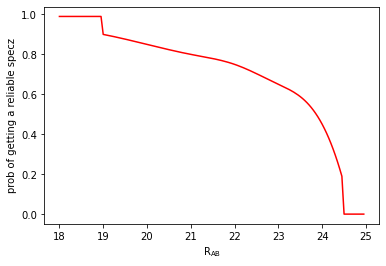

In [4]:
rab1    = [19,  20,   21,  22,   23,    24, 24.5]
pspecz1 = [0.9, 0.85, 0.8, 0.75, 0.65, 0.45, 0.15]

p1 = prob_specz(rab1, pspecz1)

plt.plot(Rab, p1(Rab), ls='-', marker='None', color='r')
plt.xlabel(r"R$_{\rm AB}$")
plt.ylabel('prob of getting a reliable specz')

## Read in an existing SNANA HOSTLIB file

The one we are using here is based on the CANDELS+3DHST galaxy catalogs. 

In [5]:
# Big file, 100k galaxies.  Use, e.g. data_end=300 for quick testing
hostlib = table.Table.read("data/candels_hostlib_v4.txt", format='ascii.basic', data_start=1, header_start=0) 

hostlib = table.Table.read("data/Akari_Hosts_subset_SNR_v7.HOSTLIB", 
                           format='ascii.basic', data_start=1, header_start=0) 

InconsistentTableError: 
ERROR: Unable to guess table format with the guesses listed below:
Reader:FastBasic data_start: 1 fast_reader: {'enable': True} fill_values: [('', '0')] header_start: 0
Reader:Basic data_start: 1 fast_reader: {'enable': True} fill_values: [('', '0')] header_start: 0
Reader:Basic data_start: 1 delimiter: '|' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: 0 quotechar: '"'
Reader:Basic data_start: 1 delimiter: '|' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: 0 quotechar: "'"
Reader:Basic data_start: 1 delimiter: ',' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: 0 quotechar: '"'
Reader:Basic data_start: 1 delimiter: ',' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: 0 quotechar: "'"
Reader:Basic data_start: 1 delimiter: ' ' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: 0 quotechar: '"'
Reader:Basic data_start: 1 delimiter: ' ' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: 0 quotechar: "'"
Reader:Basic data_start: 1 delimiter: '\\s' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: 0 quotechar: '"'
Reader:Basic data_start: 1 delimiter: '\\s' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: 0 quotechar: "'"
Reader:Basic data_start: 1 fast_reader: {'enable': True} fill_values: [('', '0')] header_start: 0

************************************************************************
** ERROR: Unable to guess table format with the guesses listed above. **
**                                                                    **
** To figure out why the table did not read, use guess=False and      **
** fast_reader=False, along with any appropriate arguments to read(). **
** In particular specify the format and any known attributes like the **
** delimiter.                                                         **
************************************************************************

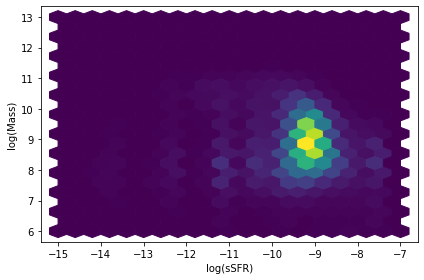

In [23]:
#histout = plt.hist2d(hostlib['logssfr'], hostlib['logmass'], bins=20, range=[[-15,-7],[6,13]])

histout = plt.hexbin(hostlib['logssfr'], hostlib['logmass'], gridsize=20, extent=[-15,-7,6,13])
ax = plt.gca()
plt.xlabel('log(sSFR)')
plt.ylabel('log(Mass)')
plt.tight_layout()


### Connect the (mock) map of redshift efficiency to this map of host galaxy properties

and fold in the probability of a galaxy hosting a SN to get the probability of getting a specz for SN host galaxies vs z. 

In [75]:
def ssnr_ah17_smooth(logssfr):
    """ Returns the Type Ia specific SN rate per Tyr 
    (number of SN Ia exploding per 10^12 yr per solar mass)
    for a galaxy, using the model of Andersen & Hjorth 2017, which is based 
    on the specific star formation rate, given as log10(SSFR).
    """
    a = 1.2e-13
    b = 0.73
    k = 0.49
    ssfr0 = 1.665e-10
    # logssfr0 = -9.778585762157661    # log10(ssfr0)
    ssfr = 10**logssfr
    ssnr = (a + (a/k) * np.log10(ssfr/ssfr0 + b)) * 1e12
    return(ssnr)

In [76]:
hostlib[:3]

VARNAMES:,GALID,RA_GAL,DEC_GAL,ZTRUE,ZERR,ZPHOT,ZPHOTERR,logsfr,logmass,logssfr,sdssu_fit,sdssg_fit,sdssr_fit,sdssi_fit,sdssz_fit,2massj_fit,2massh_fit,hst_f606w_obs,hst_f814w_obs,hst_f125w_obs,hst_f140w_obs,hst_f160w_obs,wfirst_j129_obs,wfirst_h158_obs,n0_Sersic,a0_Sersic,b0_Sersic,a_rot,coeff_specbasis00,coeff_specbasis01,coeff_specbasis02,coeff_specbasis03,coeff_specbasis04,coeff_specbasis05,coeff_specbasis06,coeff_specbasis07,coeff_specbasis08,coeff_specbasis09,coeff_specbasis10,coeff_specbasis11,coeff_specbasis12
str4,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
GAL:,100006,215.3038,53.05212,0.7217,0.0295,0.7217,0.0295,-0.39,8.51,-8.9,24.28,23.82,23.72,23.94,23.91,23.58,23.6,24.35,23.95,23.89,-999.0,23.92,24.75,23.8,0.8969,0.2655,0.116,130.1453,452121000000000.0,0.0,0.0,279498000000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,106140000000000.0
GAL:,100008,215.30321,53.05296,0.8557,0.2235,0.8557,0.2235,-0.95,8.08,-9.04,26.59,26.09,25.71,25.67,25.51,25.83,27.09,26.69,26.18,25.61,-999.0,25.6,25.78,25.7,1.0807,0.1754,0.0559,162.4201,41946200000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86524500000000.0
GAL:,100010,215.27869,53.03593,3.3584,0.1165,3.3584,0.1165,0.29,9.48,-9.19,25.42,25.05,24.72,24.62,24.66,24.99,24.65,26.44,25.61,25.47,-999.0,25.39,25.58,25.18,0.8717,0.4599,0.1957,124.4195,113684000000000.0,191886000000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


This is all very kludgy... but as a quick proof-of-concept it seems to be doing the job.  Need to capture this into a module, write some tests, make it more general, then extend it to other parameter dimensions.

In [103]:
### 1. predict the AB mag of each galaxy in the catalog
rfit = hostlib['sdssr_fit']
logssfr = hostlib['logssfr']
logmass = hostlib['logmass']


### 2. predict the probability of getting a spec-z
pspecz = p1(rfit)
pspecz /= pspecz.sum()

### 3. apply the SN rate estimation to predict SN yields
ssnr = ssnr_ah17_smooth(logssfr)
snr = ssnr * 10**logmass
netsnr = snr.sum()
psnhost = snr / netsnr

# Probability that galaxy is a SN host AND gets a spec-z
wgt = pspecz * psnhost


### 4. count up the fraction of spec-z's for SN hosts vs z, vs Rab, vs H, 
normalization_specz = pspecz.sum()
normalization_snhost = psnhost.sum()


In [123]:
all_binvals, all_binedges = np.histogram(hostlib['ZTRUE'], density=True,
                                         weights=None, bins = np.arange(0,4,0.2))

host_binvals, host_binedges = np.histogram(hostlib['ZTRUE'], 
                                           weights=psnhost, bins = np.arange(0,4,0.2))

specz_binvals, specz_binedges = np.histogram(hostlib['ZTRUE'], 
                                             weights=pspecz, bins = np.arange(0,4,0.2))

hostspecz_binvals, hostspecz_binedges = np.histogram(hostlib['ZTRUE'], 
                                                     weights=pspecz*psnhost, 
                                                     bins = np.arange(0,4,0.2))

In [124]:
Nall = all_binvals.sum()
Nhost = host_binvals.sum()
Nspecz = specz_binvals.sum()
Nhostspecz = hostspecz_binvals.sum()

In [125]:
Nall, Nhost, Nspecz, Nhostspecz

(5.000000000000001,
 0.8687335016529761,
 0.9706225061726571,
 2.3750103522543525e-05)

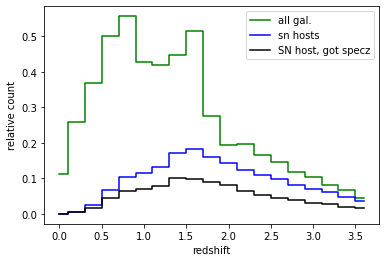

In [134]:
plt.plot(all_binedges[:-1], all_binvals, drawstyle='steps-mid', color='g', label='all gal.')
plt.plot(host_binedges[:-1], host_binvals*2, drawstyle='steps-mid', color='b', label='sn hosts')
#plt.plot(specz_binedges[:-1], specz_binvals, drawstyle='steps-mid', color='r')
plt.plot(hostspecz_binedges[:-1], hostspecz_binvals*4e4, drawstyle='steps-mid', color='k', label='SN host, got specz')
plt.xlabel('redshift')
plt.ylabel('relative count')

plt.legend()


#  OLD CODE FOLLOWS BELOW HERE

In [3]:
#sim1 = table.Table.read("WFIRST_sim_3.8sqdeg_v0.0.fits")
simcatA = table.Table.read("WFIRST_CANDELSbased_sim_0.2sqdeg_v0.0.fits")
simcatB = table.Table.read("fiducial_lensing_galaxia_truth_gal.fits")

In [37]:
simcatBid = np.array(simcatA['id'], dtype='int')
np.max(simcatB['pind']), np.max(simcatBid), len(np.unique(simcatBid))


(38306, 43943, 43944)

In [14]:
fits1 = fits.open("WFIRST_sim_3.8sqdeg_v0.0.fits")
fits2 = fits.open("WFIRST_CANDELSbased_sim_0.2sqdeg_v0.0.fits")

In [19]:
fits2dat = table.Table(fits2[1].data)

In [20]:
fits2dat

id,u_LSST,du,g_LSST,dg,r_LSST,dr,i_LSST,di,z_LSST,dz,y_WFIRST,dy,j_WFIRST,dj,h_WFIRST,dh,F184W_WFIRST,dh2,redshift,specz,flag,F160Wmag,fwhm,cstar
str10,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32
0,23.938734,0.017679926,22.866013,0.038804296,21.683353,0.009396017,20.911968,0.0090999035,20.554216,0.0077740215,99.0,28.533058,99.0,19.956892,19.68204,0.0023008352,99.0,22.262884,0.5303,0.5303,1,19.58,6.46,0.03
1,99.0,25.347076,99.0,27.667543,99.0,24.078842,99.0,30.659937,21.958466,0.027543243,99.0,28.534302,99.0,21.58368,21.419128,0.011421934,99.0,23.49343,0.264,0.2341,2,21.37,15.85,0.03
2,24.550402,0.025168598,23.888021,0.048546124,23.12927,0.02018684,22.429062,0.021632472,22.195549,0.018573873,99.0,28.534485,99.0,21.743544,21.543665,0.015525257,99.0,23.567421,0.684,0.684,1,21.48,33.95,0.0
3,23.878588,0.01266434,23.345955,0.028337868,22.824902,0.013701252,22.681498,0.026381982,22.593369,0.02472262,99.0,28.534864,99.0,22.525866,22.467594,0.022156786,99.0,24.249222,0.202,0.202,1,22.47,14.63,0.0
4,99.0,27.076235,99.0,30.553904,99.0,30.810524,99.0,30.665995,99.0,28.851114,99.0,28.541319,99.0,23.621262,23.407347,0.022356363,99.0,24.844082,1.092,-99.0,-99,23.34,5.31,0.02
5,24.671007,0.01964535,24.619003,0.050707918,24.31718,0.037341144,23.776293,0.03843128,23.656607,0.04329234,99.0,28.535767,99.0,23.477423,23.400997,0.026889937,99.0,24.88496,0.905,-99.0,-99,23.4,10.89,0.0
6,25.457365,0.03205473,25.196009,0.06763907,24.71162,0.034120303,24.137785,0.040255833,23.965786,0.036664143,99.0,28.53602,99.0,23.731033,23.6015,0.032599688,99.0,25.00533,0.761,-99.0,-99,23.57,6.15,0.01
7,23.444513,0.009678669,23.371159,0.03545526,22.917202,0.025485313,22.42411,0.032789238,22.031744,0.022470726,99.0,28.534298,99.0,21.61086,21.492044,0.0069723083,99.0,23.558609,1.086,1.0925,2,21.47,10.09,0.02
8,29.325542,2.0586677,25.99555,0.6580172,25.910305,0.49175054,99.0,26.455927,99.0,29.869574,99.0,28.541319,99.0,21.723608,21.957226,0.03473858,99.0,23.994398,7.895,-99.0,-99,22.1,26.12,0.36


In [3]:
# Define a dict that translates a fieldname into an integer that matches the 
# 3DHST 'ifield' entry.  Note that AEGIS and EGS are the same field.
ifield_dict = {'aegis':1, 'egs':1, 'cosmos':2, 'goodsn':3, 'goodss':4, 'uds':5}

In [4]:
# Set limits for the allowable Star formation rate and mass ranges
# to be included in the catalogs and weight maps.
_LOGSSFR_MIN=-50
_LOGSSFR_MAX=-5
_LOGMASS_MIN=3
_LOGMASS_MAX=13

### Preamble: computing HST+WFC3 to WFIRST+WFI filter color terms

In [5]:
# read in the filter data, downloaded from http://svo2.cab.inta-csic.es/svo/theory//fps3/
# also available at: https:// wfirst.gsfc.nasa.gov/science/sdt_public/wps/references/ instrument/WFIRST-WFI-Transmission_160720.xlsm
J_hst = ascii.read("HST_WFC3_IR.F125W.dat")
H_hst = ascii.read("HST_WFC3_IR.F160W.dat")
J_wfirst = ascii.read("WFIRST_WFI.J129.dat")
H_wfirst = ascii.read("WFIRST_WFI.H158.dat")

# Define the AB mag zero-points 
# from HST WFC3 data tables www.stsci.edu/hst/wfc3/phot_zp_lbn
# and from Hounsell+ 2018  (which references the wfirst spreadsheet linked above)
zpt_J_hst = 26.25
zpt_H_hst = 25.96
zpt_J_wfirst = 26.35
zpt_H_wfirst = 26.41

Text(0, 0.5, 'Filter Transmission')

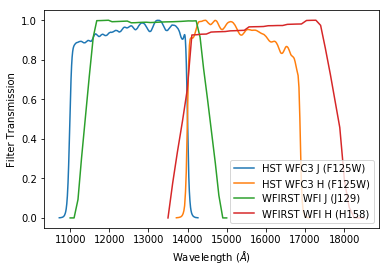

In [6]:
# make a plot showing the transmission curves
for filt, filtname in zip([J_hst, H_hst, J_wfirst, H_wfirst],
                          ['HST WFC3 J (F125W)', 'HST WFC3 H (F125W)', 
                          'WFIRST WFI J (J129)', 'WFIRST WFI H (H158)']):
    plt.plot(filt['col1'], filt['col2']/filt['col2'].max(), label=filtname)
plt.legend(loc='lower right')
ax = plt.gca()
ax.set_xlabel(r'Wavelength ($\AA$)')
ax.set_ylabel('Filter Transmission')

In [7]:
# compute the HST to WFIRST filter transformation offsets
def integrate_bandpass(band):
    wave = band['col1']
    transmission = band['col2']/band['col2'].max()
    return(integrate.trapz(transmission, wave))

J_hst_tot = integrate_bandpass(J_hst)
J_wfi_tot = integrate_bandpass(J_wfirst)
H_hst_tot = integrate_bandpass(H_hst)
H_wfi_tot = integrate_bandpass(H_wfirst)

# The magnitude value to add to an HST observed magnitude to change it
# into the equivalent WFIRST magnitude
delta_mAB_J_hst_to_wfirst = (-2.5*np.log10(J_wfi_tot/J_hst_tot) 
                             + zpt_J_wfirst - zpt_J_hst)

delta_mAB_H_hst_to_wfirst = (-2.5*np.log10(H_wfi_tot/H_hst_tot) 
                             + zpt_H_wfirst - zpt_H_hst)

### Read in the master 3DHST catalog

This catalog has two columns that define a unique object identifier:  
- ifield : integer number for each field
  - 1 : aegis (egs)
  - 2 : cosmos
  - 3 : goodsn
  - 4 : goodss
  - 5 : uds
- phot_id  = runs from 1 to N for each field, counting phot objects (galaxies) 
  - Note: max N is about 50,000
  
We make a unique object ID ('obj_id') by multiplying the ifield by 10^5 and adding the phot_id.


In [8]:
cat3dhst = table.Table.read("3dhst.v4.1.5.master.fits")
objid_column = table.Column(data=cat3dhst['ifield']*100000 + cat3dhst['phot_id'], name='obj_id')
cat3dhst.add_column(objid_column, index=0)

### Define functions for merging EazyPy and GalFit parameters with the 3DHST data

For each field we add EazyPy results (SED fitting parameters) and then GalFit results (Sersic profile parameters) by defining a matching obj_id column and doing an inner join with the 3DHST catalog.

In [9]:
def get_eazypy_data(fieldname):
    """Read in the EazyPy data (best-fit SED coefficients) for the given field"""
    filepath_data = 'eazypy/{0}_3dhst.v4.1.eazypy.data.fits'.format(fieldname)
    assert os.path.exists(filepath_data)
    datahdu = fits.open(filepath_data)

    # make an object ID that carries the field in the highest-value digit    
    objid_data = datahdu['ID'].data + ifield_dict[fieldname] * 100000
    objid_column = table.Column(data=objid_data, name='obj_id')

    # make a column with the sum of coefficients (sum=0 means no usable fit)
    coeff_sum_data = np.sum(datahdu['COEFFS'].data, axis=1)
    coeff_sum_column = table.Column(data=coeff_sum_data, name='coeff_sum')

    coeff_table = table.Table(datahdu['COEFFS'].data)
    for i in range(len(coeff_table.columns)):
        coeff_table.columns[i].name = 'eazy_coeff{0:02d}'.format(i)
    coeff_table.add_column(coeff_sum_column, index=0)
    coeff_table.add_column(objid_column, index=0)
    return(coeff_table)

In [10]:
def mk_galfit_filepath(fieldname, filtername):
    """Construct the 3DHST catalog file path for the given field"""
    filepath = '{0}/{0}_3dhst.v4.1_{1}.galfit'.format(fieldname, filtername)
    assert os.path.exists(filepath)
    return(filepath)

def mk_merged_catalog(fieldname, trim_unusable=True, checkradec=True,
                     verbose=True):
    """Do an inner merge of a GalFit catalog with the 3DHST catalog, then do an 
    inner merge of an EazyPy coefficients table with the merged GalFit+3DHST catalog.
    
    trim_unusable : exclude galaxies with bad sersic 
                    fits, no redshift, or no SSFR measure
                    
    checkradec : do a consistency check on the merge by verifying 
                 consistent coordinate positions.
    """
    ifield = ifield_dict[fieldname]

    # Get the EazyPy coefficients data
    cateazypy = get_eazypy_data(fieldname)
    
    # Get the GalFit data
    galfit_f125w_filepath = mk_galfit_filepath(fieldname, 'f125w')
    galfit_f160w_filepath = mk_galfit_filepath(fieldname, 'f160w')
    
    catgalfit = table.Table.read(galfit_f160w_filepath, format='ascii.commented_header')
    objid_column = table.Column(data=ifield*100000 + catgalfit['NUMBER'], name='obj_id')
    catgalfit.add_column(objid_column, index=0)
    catgalfit.rename_column('RA', 'ra_galfit')
    catgalfit.rename_column('DEC', 'dec_galfit')
    catgalfit.rename_column('mag', 'mag_f160w')
    catgalfit.rename_column('dmag', 'dmag_f160w')

    # Add a column the observed F125W mag from the Sersic fits
    # (we already have the F160W mags)
    cat125 = table.Table.read(galfit_f125w_filepath, format='ascii.commented_header')
    cat125.rename_column('mag', 'mag_f125w')
    cat125.rename_column('dmag', 'dmag_f125w')
       
    i160 = catgalfit.index_column('mag_f160w')
    catgalfit.add_columns([cat125['mag_f125w'],cat125['dmag_f125w']], indexes=[i160, i160] )
    

    # Add columns with the WFIRST J129 and H158 mags, 
    # using the HST-to-WFIRST offsets computed above
    col129 = table.Column(data=cat125['mag_f125w']+delta_mAB_J_hst_to_wfirst,
                         name='mag_j129')
    col158 = table.Column(data=catgalfit['mag_f160w']+delta_mAB_H_hst_to_wfirst,
                         name='mag_h158')
    catgalfit.add_columns([col129, col158], indexes=[i160, i160] )

    
    # Merge the 3dHST and GalFit and EazyPy catalogs with an inner join, matching 
    # on the obj_id column, which is the Skelton 2014 galaxy id. 
    catmerged0 = table.join(cat3dhst, catgalfit, join_type='inner', keys=['obj_id'])
    catmerged = table.join(catmerged0, cateazypy, join_type='inner', keys=['obj_id'])
    
    if trim_unusable:
        # limit to only galaxies that have good galfit data (flag=0) 
        # good galaxy properties (sfr, mass) and good
        # redshifts (zbest>0), so they'll deliver a good SN rate.
        ivalid = np.where((catmerged['f']<1) & 
                          (catmerged['z_best']>0) & 
                          (catmerged['lssfr']>_LOGSSFR_MIN) &
                          (catmerged['lssfr']<_LOGSSFR_MAX) &
                          (catmerged['lmass']>_LOGMASS_MIN) &
                          (catmerged['lmass']<_LOGMASS_MAX) & 
                          (catmerged['coeff_sum']>0)
                         )[0]
        if verbose:
            print("Selected {0} of {1} galaxies".format(
                len(ivalid), len(catmerged)) + 
              "  with ok redshifts, Sersic fits, sSFR, and mass data.")
        catmerged = catmerged[ivalid]
        
    if checkradec:
        # If all of our objects are positional matches, then none should 
        # be offset by more than 0.01 arcsec in either direction
        delta_ra_max_arcsec = np.max( 
            np.abs(catmerged['ra'] - catmerged['ra_galfit']) 
            * np.cos(catmerged['dec'])) * 3600.
        delta_dec_max_arcsec = np.max(
            np.abs(catmerged['dec'] - catmerged['dec_galfit'])) * 3600.
        assert delta_ra_max_arcsec < 0.06
        assert delta_dec_max_arcsec < 0.06
        if verbose:
            print("{} galfit catalog merged with 3DHST catalog successfully.".format(fieldname))
            print("Max RA discrepancy = {} arcsec".format(delta_ra_max_arcsec))
            print("Max Dec discrepancy = {} arcsec".format(delta_dec_max_arcsec))
            
    return(catmerged)


### Define functions for Computing SN rates for each galaxy
And show us a plot of the function

Text(0.5, 0, 'log10( sSFR [yr-1] )')

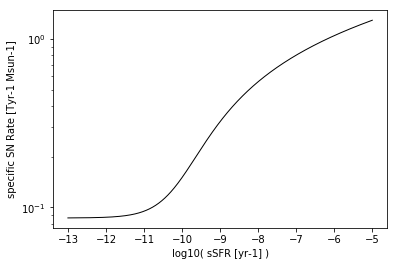

In [12]:
# Show the SN Rate model from Andersen & Hjorth 2017
#cat = aegis_cat
#cat = cosmos_cat
#lssfrcat = cat['lssfr']
#ssnrcat = snr_ah17_smooth(lssfrcat)

lssfr_testvals = np.linspace(-13., -5., 1000)
ssnr = ssnr_ah17_smooth(lssfr_testvals)

#plt.semilogy(lssfrcat, ssnrcat, marker='.', ms=2, alpha=0.5, ls=' ', color='r')
plt.semilogy(lssfr_testvals, ssnr, marker=' ', ls='-', lw=1, color='k')
ax = plt.gca()
ax.set_ylabel("specific SN Rate [Tyr-1 Msun-1]")
ax.set_xlabel("log10( sSFR [yr-1] )")

### Define a function to add a SN rate column to a catalog
This predicted SN Rate per galaxy will define the weight in the WGTMAP for a SNANA HOSTLIB file.

We also trim out bad entries from the catalog (missing redshift, Sersic fit, or info required for the SN rate).

In [13]:
def mk_weight_column(catalog, snr_model='AH17', verbose=True):
    """Add a column to the given catalog that gives the relative probability
    for each galaxy hosting a SN in any given observer-frame year.  This is
    computed based on the predicted SN rate (number of SN explosions per 
    observer-frame year) of each galaxy, adopting the specified
    SN rate model.  
        
    snr_model='A+B' : SNR = A*M + B*SFR   (Scannapieco & Bildsten 2005)
             ='AH17' : the smooth logarithmic sSFR model (Andersen & Hjorth 2017)
             
    """
    if snr_model.lower()=='a+b':
        # Note: adopting the A and B values from Andersen & Hjorth 2017
        # but dividing by 1e-4 (so the SNR below actually counts the number of 
        # SN explodiing per 10000 yrs)
        A = 4.66 * 1e-10
        B = 4.88  
        snr = A * 10**catalog['lmass'] + B * 10**catalog['lsfr']
        # divide by the total snr to get relative probabilities
        snr /= np.nanmax(snr)
        snrcol = table.Column(data=snr, name='snr_A+B')
        if 'snr_A+B' in catalog.colnames:
            catalog['snr_A+B'] = snr
        else:
            catalog.add_column(snrcol)
    elif snr_model.lower().startswith('ah17'):
        a = 1.2e-13
        b = 0.73
        k = 0.49
        ssfr0 = 1.665e-10
        ssfr = 10**(catalog['lsfr']-catalog['lmass'])
        ssnr = a + (a/k) * np.log10(ssfr/ssfr0 + b)
        snr = ssnr * 10**catalog['lmass']
        snr /= np.nanmax(snr)
        snrcolname = 'snr_AH17_smooth'
        snrcol = table.Column(data=snr, name=snrcolname)
        if snrcolname in catalog.colnames:
            catalog[snrcolname] = snr
        else:
            catalog.add_column(snrcol)
   
    if verbose:
        print("Added/updated SN rate weight column using {} model".format(snr_model))      

    return(catalog)

### Converting to a HOSTLIB

Extract just the useful information (useful to SN sims) for each galaxy and write it out to a SNANA HOSTLIB file. 
From the 3DHST catalog we get redshift, position and magnitude information: 

- z : best redshift from the 3DHST catalog
- RA, Dec
- observed AB mags in SDSS u,g,r,i,z and 2MASS J, H


The GalFit catalogs from Arjen Van Der Weil contain the following columns:

- COL 1,  NUMBER: ID from the Skelton et al. (2014) photometric catalogs from the 3D-HST team
- COL 2,  RA: from SExtractor, measured in F160W
- COL 3,  DEC: idem.
- COL 4,  f: FLAG value (0: good fit; 1: suspicious fit; 2: bad fit; 3: no fit -- see van der Wel et al. 2012)
- COL 5,  mag: total AB magnitude from best-fitting Sersic model (GALFIT)
- COL 6,  dmag: 1-sigma uncertainty in mag
- COL 7,  re: semi-major axis in arcsec of the ellipse that contains half of the total light in the best fitting Sersic model
- COL 8,  1-sigma uncertainty on re
- COL 9,  n: Sersic index of the best-fitting Sersic model
- COL 10, dn: 1-sigma uncertainty on n
- COL 11, q: axis ratio of the best fitting Sersic model
- COL 12, dq: 1-sigma uncertainty on q
- COL 13, pa: position angle in degrees (0: North; 90: East)
- COL 14, dpa: 1-sigma uncertainty on pa
- COL 15, sn: S/N as measured in the F???W filter, integrated over the F160W segmentation region

For the HOSTLIB file we get Sersic fit info, and HST J and H band magnitudes from this catalog. 


There are two sets of functions:  
- one set for defining the HOSTLIB entries (a header and a line for each galaxy)
- another set for making a weight map in the HOSTLIB (defining the weight based on the predicted SN rate per galaxy). 


In [14]:

_HOSTLIB_HEADER = """
VARNAMES: GALID RA_GAL  DEC_GAL      ZTRUE      ZERR     ZPHOT  ZPHOTERR    logsfr   logmass  logssfr hstj_obs  hsth_obs n0_Sersic a0_Sersic b0_Sersic a_rot eazy_coeff00 eazy_coeff01 eazy_coeff02 eazy_coeff03 eazy_coeff04 eazy_coeff05 eazy_coeff06 eazy_coeff07 eazy_coeff08 eazy_coeff09 eazy_coeff10 eazy_coeff11 eazy_coeff12

"""

    
def mk_hostlib_line(linedat):
    """ Extract galaxy info  that is useful for SN simulations from a 
    merged 3DHST+GalFit catalog.  Return a string in the SNANA HOSTLIB format
    """
    # question for Rick Kessler: can a SNANA HOSTLIB handle asymmetric z errors? 
    zbesterr = (linedat['z_best_u68']-linedat['z_best_l68'])/2.   # assuming 'No.'
    zphoterr = (linedat['z_phot_u68']-linedat['z_phot_l68'])/2.   # assuming 'No.'

    # Galfit: pa: position angle in degrees (0: North; 90: East)
    # SNANA:  “a_rot” is the rotation angle (in degrees) of the major axis w.r.t. the +RA coordinate. 
    # If North is up and East is to the right, a_rot is measured clockwise, from the East toward the South.
    a_rot = linedat['pa'] - 90 
    if a_rot < 0 : 
        a_rot += 180

    outline = ("GAL: {:1} " + 2*"{:10.5f}"+ 7*"{:10.4f}" + 
               2*"{:8.2f}"+ 4*"{:10.4f}" + 
               13*"{:12.5e}" + "\n").format(
        linedat['obj_id'], linedat['ra'], linedat['dec'], 
        linedat['z_best'], zbesterr, linedat['z_peak_phot'], zphoterr, 
        linedat['lsfr'], linedat['lmass'], linedat['lssfr'],
        #-2.5*np.log10(linedat['L156'])+25, 
        #-2.5*np.log10(linedat['L157'])+25, 
        #-2.5*np.log10(linedat['L158'])+25, 
        #-2.5*np.log10(linedat['L159'])+25, 
        #-2.5*np.log10(linedat['L160'])+25, 
        #-2.5*np.log10(linedat['L161'])+25, 
        #-2.5*np.log10(linedat['L162'])+25, 
        linedat['mag_j129'], linedat['mag_h158'],
        linedat['n'], linedat['re'], linedat['re']*linedat['q'], a_rot, 
        linedat['eazy_coeff00'], linedat['eazy_coeff01'], linedat['eazy_coeff02'], 
        linedat['eazy_coeff03'], linedat['eazy_coeff04'], linedat['eazy_coeff05'], 
        linedat['eazy_coeff06'], linedat['eazy_coeff07'], linedat['eazy_coeff08'], 
        linedat['eazy_coeff09'], linedat['eazy_coeff10'], linedat['eazy_coeff11'], 
        linedat['eazy_coeff12']
    )
    return(outline)

In [15]:

# First option for a weight map: 
#   use the sSFR to define the weight and host mass to define the SN mag shift. 
#  The weight map is defined with a few dozen points and SNANA is left to
# interpolate between them.

_WGTMAP_HEADER_SSFR = """
VARNAMES_WGTMAP: logssfr logmass  WGT SNMAG_SHIFT

"""

def mk_wgtmap_block(snr='AH17_smooth', 
                    logssfr_stepsize=0.5, 
                    logmass_stepsize=0.5):
    """ 
    Construct the HOSTLIB weight map: a block of text, with 
    each line including N-2 observable host galaxy parameters, and the 
    last two giving WGT and SNMAGSHIFT.  
    
    WGT is the weight (relative probability of hosting a SN Ia)
    assigned for the preceding set of galaxy parameters.  
    SNMAGSHIFT is the magnitude shift applied toa SN with the matching
    set of host galaxy parameters. 
    
    SNANA will do interpolation between the host galaxy parameter 
    values given in the WGTMAP to assign a WGT and SNMAGSHIFT to each 
    simulated SN host galaxy in the HOSTLIB section, which follows 
    below the WGTMAP. 
    """
    wgtmap_str = '\n\n'
    logssfr_gridpoints = np.arange(_LOGSSFR_MIN,
                                   _LOGSSFR_MAX + logssfr_stepsize, 
                                   logssfr_stepsize)
    logmass_gridpoints = np.arange(_LOGMASS_MIN,
                                   _LOGMASS_MAX + logmass_stepsize, 
                                   logmass_stepsize)
    massstep_values = np.where(logmass_gridpoints<10, 0.0, 0.04)
    for lssfr in logssfr_gridpoints:
        ssnr = ssnr_ah17_smooth(lssfr)
        for imass in range(len(logmass_gridpoints)):
            wgt = ssnr * np.power(10,logmass_gridpoints[imass])
            wgtmap_str += "WGT: {:8.3f} {:8.3f} {:8.3f} {:6.2f}\n".format(
                lssfr, logmass_gridpoints[imass], wgt, massstep_values[imass]
            )
            
    wgtmap_str += '\n\n'
    return(wgtmap_str)


   
# The second option : specify a weight and mag shift for each galaxy individually
# so the weight map is defined point by point for each unique GALID 
_WGTMAP_HEADER_GALID = """
VARNAMES_WGTMAP: GALID WGT SNMAG_SHIFT

"""  
    
def mk_wgtmap_galid(linedat, snrcolname='snr_AH17_smooth'):
    """ Construct a weight line for the given single line of galaxy data.  
    Return a string in the SNANA HOSTLIB WGTMAP format
    """
    outline = ("WGT: {:1} {:14.5e}  {:10.5f} \n").format(
        linedat['obj_id'], linedat[snrcolname], 0.0)
    return(outline)

### These two functions bring it all together
1. construct a weight map file that can apply to any CANDELS/3DHST-based HOSTLIB
2. constructing a HOSTLIB file from an input merged catalog

In [16]:
def mk_wgtmap_file(wgtmapfilename):
    """Make a SNANA HOSTLIB WGTMAP file that defines a parameterized
    weightmap using the Andersen & Hjorth 2017 SN rate model, which 
    predicts the SN rate for each galaxy based on that galaxy's sSFR.
    """    
    fout = open(wgtmapfilename, mode='w')
    fout.write(_WGTMAP_HEADER_SSFR)
    wgtmap_block = mk_wgtmap_block()
    fout.write(wgtmap_block)
    fout.close()
    return

def mk_hostlib_file(cat, hostlib_filename, clobber=True, verbose=True):
    """Construct a SNANA HOSTLIB file from the given catalog, which must be the 
    result of merging a 3DHST and a GalFit catalog. 
    """
    if not clobber and os.path.exists(hostlib_filename):
        print("{} exists. Not clobbering.".format(hostlib_filename))
        return(-1)    
        
    fout = open(hostlib_filename, mode='w')
    fout.write(_HOSTLIB_HEADER)
    for i in range(len(cat)):
        fout.write(mk_hostlib_line(cat[i]))
    fout.close()
    return

## Interlude:  checking on some of the peculiarly large high-z galaxies

In [17]:
fieldname = 'cosmos'
cat_trim = mk_merged_catalog(fieldname)
cat_trim = mk_weight_column(cat_trim, snr_model='AH17')

Selected 18499 of 33879 galaxies  with ok redshifts, Sersic fits, sSFR, and mass data.
cosmos galfit catalog merged with 3DHST catalog successfully.
Max RA discrepancy = -0.0 arcsec
Max Dec discrepancy = 0.0018000000002516003 arcsec
Added/updated SN rate weight column using AH17 model


/usr/local/anaconda3/envs/astroconda/lib/python3.7/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/usr/local/anaconda3/envs/astroconda/lib/python3.7/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


### identify galaxies that are unusually large

In [18]:
FLCDM = FlatLambdaCDM(H0=70, Om0=0.3)
z = np.array(cat_trim['z_best'])
mu = FLCDM.distmod(z).value
a0 = np.array(cat_trim['re'])  # Sersic fit major axis length in arcsec
M = cat_trim['mag_h158']-mu
a0_thresh = 3
ibig = np.where(a0>a0_thresh)[0]

In [19]:
def plot_hexbin_scatter(ax, xval, yval, xlabel='x values', ylabel='y values'):
    """Plot yval vs xval as a combined hexbin and scatter plot, highlighting in red 
    the galaxies that are unusually large"""
    ax.plot(xval, yval, color='k', ms=2, marker='.', ls=' ', zorder=-10)
    hexbinout = ax.hexbin(xval, yval, gridsize=30, cmap=cm.Greys_r, mincnt=20, zorder=10)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.plot(xval[ibig], yval[ibig], color='r', ms=3, 
            marker='.', ls=' ', zorder=10)
    return(hexbinout)

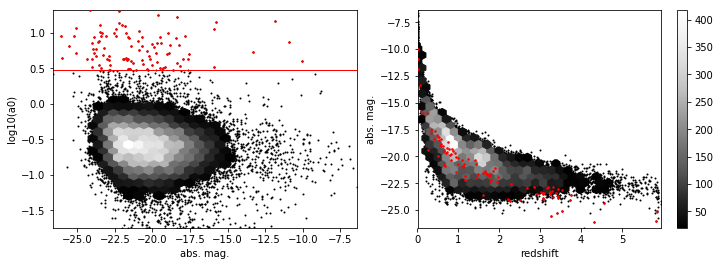

In [20]:
fig = plt.figure(figsize=[12,4])
ax1 = fig.add_subplot(121)

xval = M
yval = np.log10(a0)
plot_hexbin_scatter(ax1, xval, yval, xlabel='abs. mag.', ylabel='log10(a0)')
ax1.axhline(np.log10(a0_thresh), color='r', lw=1)

ax2 = fig.add_subplot(122)
xval = z
yval = M
hexbinout = plot_hexbin_scatter(ax2, xval, yval, xlabel='redshift', ylabel='abs. mag.')
ax.plot(np.log10(z), M-np.log10(z)*6, marker='.', ls=' ',ms=2)

plt.colorbar(hexbinout)

### Show thumbnails for some unusually large galaxies

In [21]:
from astropy import coordinates
from astropy import units as u

In [22]:
# Read in the COSMOS mosaic
mosaic = fits.open("mosaics/hlsp_candels_hst_wfc3_cos-tot_f160w_v1_0_drz.fits")
wcsobj = WCS(mosaic[0].header)

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


In [23]:
ra_big = np.array(cat_trim['ra'][ibig])*u.degree
dec_big = np.array(cat_trim['dec'][ibig])*u.degree
x_big, y_big = wcsobj.wcs_world2pix(ra_big, dec_big, 1)


ra = np.array(cat_trim['ra'])*u.degree
dec = np.array(cat_trim['dec'])*u.degree
x_all, y_all = wcsobj.wcs_world2pix(ra, dec, 1)

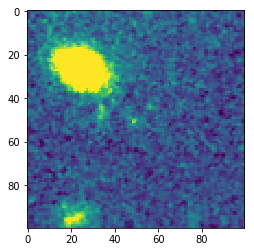

In [24]:
i=ibig[10]
x,y = int(x_all[i]), int(y_all[i])
dxy=50 # half of the stamp size
mosaic_stamp = mosaic[0].data[y-dxy:y+dxy,x-dxy:x+dxy]
plt.imshow(mosaic_stamp, vmin=-0.01, vmax=0.03)

## Define functions for Summmary plots from a trimmed catalog

In [25]:
def plot_weighted_redshift_hist(z, weights, axnum=1, binsize=0.2, label='', 
                                ncol=4, nrow=2, fig=None, **kwargs):    
    if fig is None:
        fig = plt.gcf()
    ax = fig.add_subplot(nrow, ncol, axnum)
    histout = ax.hist(z, bins=np.arange(0,5,binsize), range=(0,5), weights=weights, 
                      **kwargs)
    ax.set_xlabel('redshift')
    ax.set_ylabel(label)
    return(ax)

def plot_catalog_summary(cat, catalog_name):
    """
    Make some plots showing summaries of the SN host galaxy catalog data
    """
    fig = plt.figure(figsize=[12,7])
    fig.subplots_adjust(wspace=0.4, hspace=0.4)

    z = cat['z_best']
    snr = cat['snr_AH17_smooth']
    sfr = 10**cat['lsfr']
    mass = 10**cat['lmass']    

    # total SNR, binned by redshift
    ax2 = plot_weighted_redshift_hist(z, snr, 
                                      axnum=2, color='b', histtype='step', lw=2, 
                                      label = 'SN Rate [yr-1]')

    # total SFR, binned by redshift
    ax3 = plot_weighted_redshift_hist(z, sfr, axnum=3, color='darkorange', histtype='step', lw=2, 
                                      label = 'SFR [Msun yr-1]')


    # total mass, binned by redshift
    ax4 = plot_weighted_redshift_hist(z, mass, axnum=4, color='g', histtype='step', lw=2, 
                                      label = 'Galaxy Mass [Msun]')

    # Histogram of redshifts
    ax5 = fig.add_subplot(2, 4, 5)
    ax5.set_ylabel('Galaxy Count')
    histout = ax5.hist(z, bins=np.arange(0,5,0.2), color='r')
    ax5.set_xlabel('redshift')


    # histogram of galaxy masses ( log10(mass) )
    ax5 = fig.add_subplot(2, 4, 8)
    histout = ax5.hist(cat['lmass'], bins=np.arange(5,13,0.2), color='g')
    ax5.set_xlabel('log10(Mass/Msun)')

    # histogram of Sersic index
    ax6 = fig.add_subplot(2, 4, 7)
    histout = ax6.hist(cat['n'], color='m')#, bins=np.arange(5,13,0.2), color='0.5')
    ax6.set_xlabel('Sersic Index')

    ax7 = fig.add_subplot(2, 4, 6)
    histout = ax7.hist(cat['snr_AH17_smooth'], bins=np.linspace(0,0.05,50), color='b')
    ax7.set_yscale('log')
    ax7.set_xlabel('SN Rate')


    catalog_info = """
{0}\n
N = {1:d}
""".format(catalog_name, len(cat))
    fig.text(0.1, 0.9, catalog_info, transform=fig.transFigure, ha='left', va='top',
            fontsize=18)

In [26]:
def plot_mag_hist_at_z(cat, zval, band='V_rest', dz=0.1, ax=None):
    if ax is None:
        ax = plt.gca()
    iz = np.where((cat['z_best']<zval+dz) & (cat['z_best']>zval-dz))[0]

    if band=='U_rest':
        m = 25. - 2.5*np.log10(cat['L135'][iz])
    elif band=='V_rest':
        m = 25. - 2.5*np.log10(cat['L137'][iz])
    elif band=='I_rest':
        I = 25. - 2.5*np.log10(cat['L139'][iz])
    elif band=='u':
        m = 25. - 2.5*np.log10(cat['L156'])[iz]
    elif band=='r':
        r = 25. - 2.5*np.log10(cat['L158'])[iz]
    elif band=='z':
        z = 25. - 2.5*np.log10(cat['L160'])[iz]

        #plt.scatter(u-r, r-z, marker='.', color='k', alpha=0.2)
    histout = ax.hist(m, bins=np.arange(18,30,0.5))
    ax.text(0.05, 0.95, "z={:.2f}+-{:.2f}".format(zval,dz), transform=ax.transAxes,
           ha='left', va='top', fontsize=14)
    return
    
def plot_restV_histograms(cat, field_name):
    fig = plt.figure(figsize=[12,8])
    #fig.subplots_adjust(wspace=0.4, hspace=0.2)
    ax1 = fig.add_subplot(2, 4, 1)

    for i in range(1,9):
        if i>1:
            ax = fig.add_subplot(2, 4, i, sharey=ax1)
        else:
            ax = ax1
        plot_mag_hist_at_z(cat, zval=0.4*i, dz=0.2, band='V_rest', ax=ax)
    #ax1.set_ylim(0,800)
    fig.text(0.5, -0.05, "Apparent Magnitude in rest-frame V band", 
             transform=fig.transFigure, ha='center', va='bottom', fontsize=18)
    fig.text(-0.05, 0.5, "Number of Galaxies in {} Catalog".format(field_name),
             transform=fig.transFigure, ha='left', va='center', 
             fontsize=18, rotation=90)
    plt.tight_layout()
    return


## Make the files for SNANA and summary plots for All 5 CANDELS Fields

* First make a weight map file (common for all fields)
* then for each  merged catalog: 
  * compute SN rates and trim bad entries
  * construct the HOSTLIB file

In [27]:
mk_wgtmap_file('wgtmap_for_candels3dhst_hostlibs.txt')

Selected 21684 of 41200 galaxies  with ok redshifts, Sersic fits, sSFR, and mass data.
aegis galfit catalog merged with 3DHST catalog successfully.
Max RA discrepancy = -0.0 arcsec
Max Dec discrepancy = 0.0018000000210349754 arcsec
Added/updated SN rate weight column using AH17 model


Selected 21994 of 50507 galaxies  with ok redshifts, Sersic fits, sSFR, and mass data.
goodss galfit catalog merged with 3DHST catalog successfully.
Max RA discrepancy = -0.0 arcsec
Max Dec discrepancy = 0.0070200000052977884 arcsec
Added/updated SN rate weight column using AH17 model


Selected 18346 of 38279 galaxies  with ok redshifts, Sersic fits, sSFR, and mass data.
goodsn galfit catalog merged with 3DHST catalog successfully.
Max RA discrepancy = 0.05016221986368405 arcsec
Max Dec discrepancy = 0.01407600001357423 arcsec
Added/updated SN rate weight column using AH17 model


Selected 18499 of 33879 galaxies  with ok redshifts, Sersic fits, sSFR, and mass data.
cosmos galfit catalog merged with 3DH

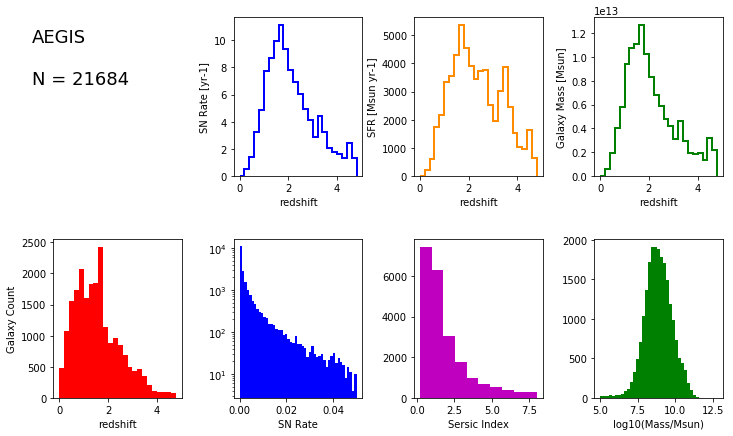

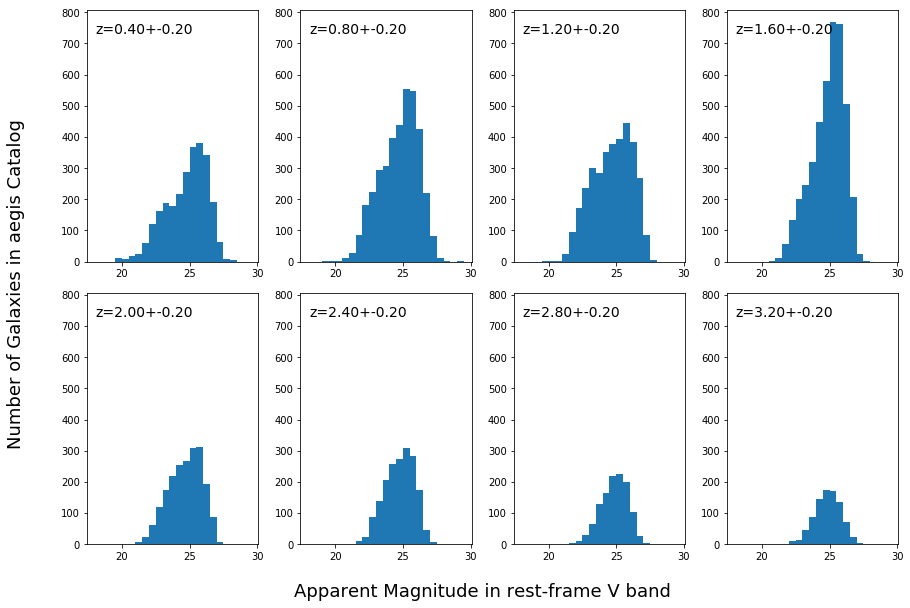

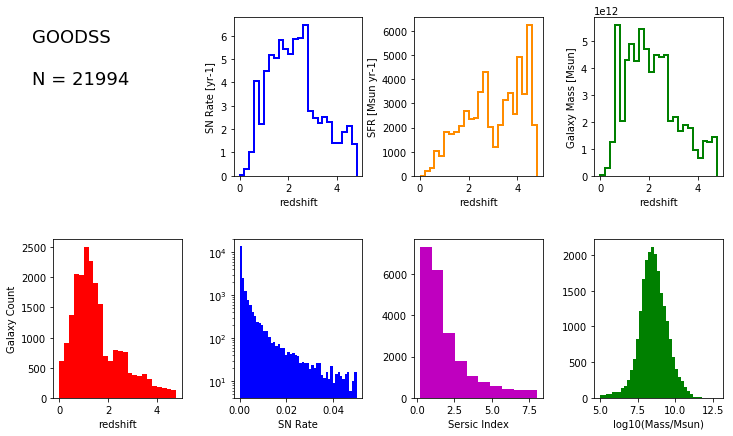

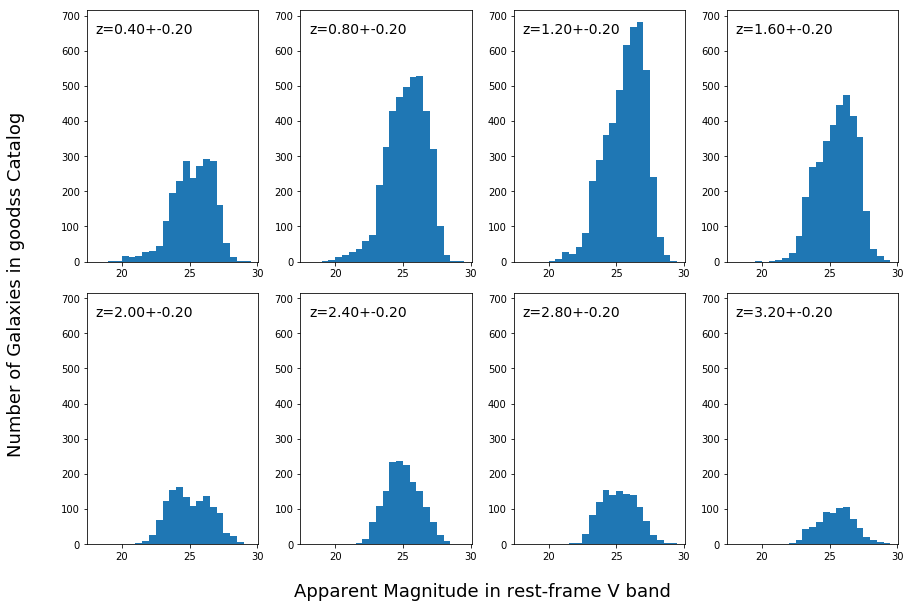

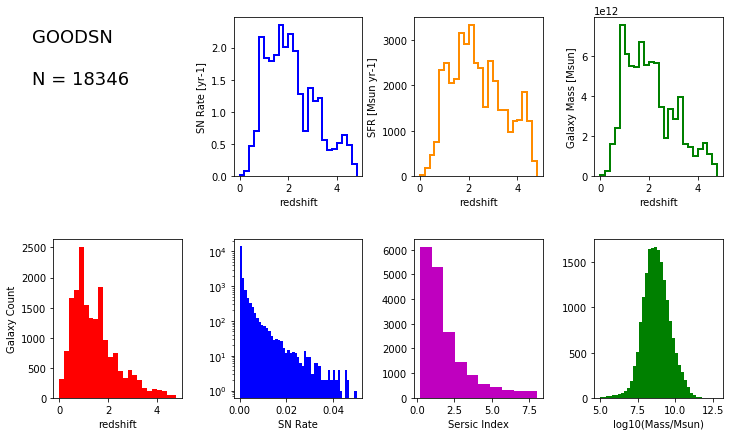

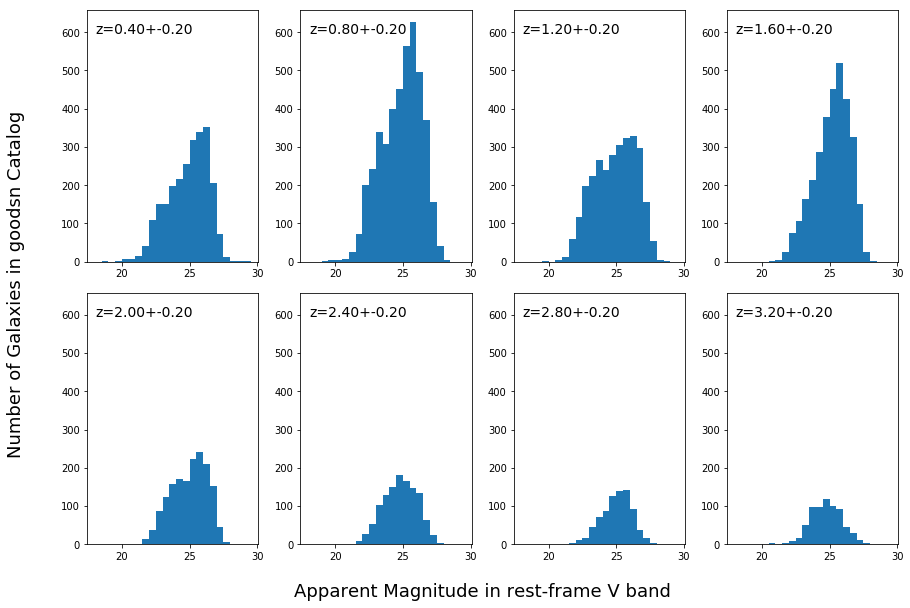

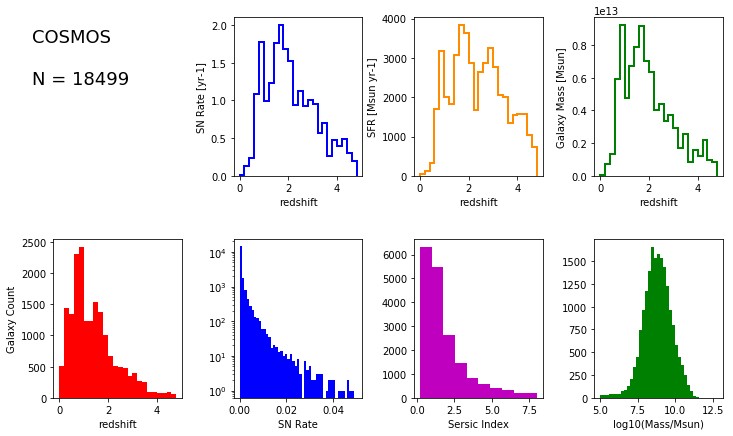

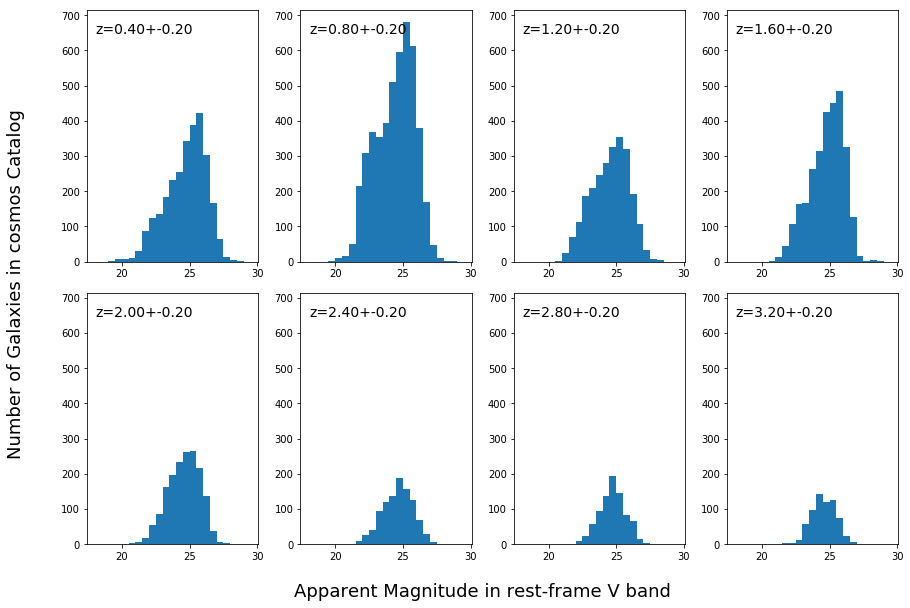

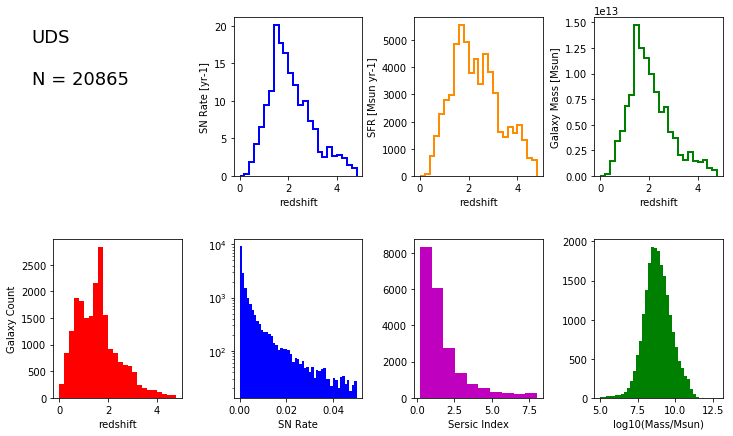

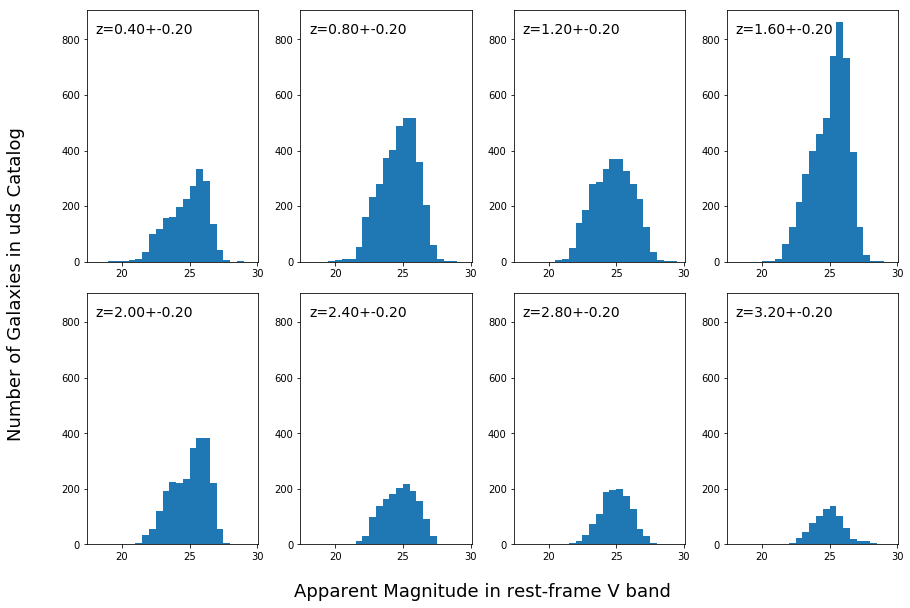

In [28]:
catlist = []
for fieldname in ['aegis', 'goodss', 'goodsn', 'cosmos', 'uds']:
    cat_trim = mk_merged_catalog(fieldname)
    cat_trim = mk_weight_column(cat_trim, snr_model='AH17')
    catlist.append(cat_trim)
    mk_hostlib_file(cat_trim, '{}_hostlib.txt'.format(fieldname))
    print('\n')
    plot_catalog_summary(cat_trim, fieldname.upper())
    plt.savefig("{}_catalog_summary.png".format(fieldname))

    plot_restV_histograms(cat_trim, fieldname)
    plt.savefig("{}_catalog_mag_hist.png".format(fieldname))

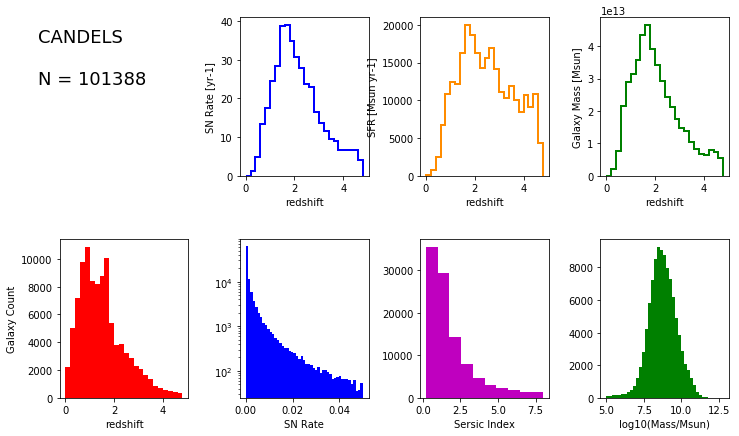

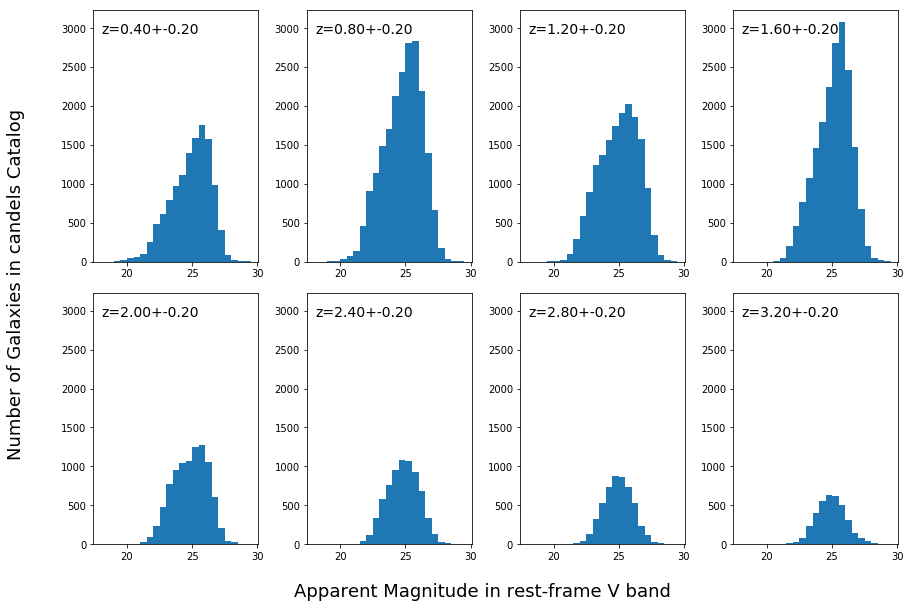

In [29]:
cat_trim = table.vstack(catlist, join_type='exact')
fieldname = 'candels'

mk_hostlib_file(cat_trim, '{}_hostlib.txt'.format(fieldname))
print('\n')

plot_catalog_summary(cat_trim, fieldname.upper())
plt.savefig("{}_catalog_summary.png".format(fieldname))

plot_restV_histograms(cat_trim, fieldname)
plt.savefig("{}_catalog_mag_hist.png".format(fieldname))


### Write out the EazyPy spectral templates

Extract the EazyPy template data from any of the EazyPy catalog files, and write out as separate ascii data files.

In [30]:
def mk_eazypy_template_datafile(outfilename='eazy_13_spectral_templates.dat'):
    fieldname = 'uds'  # any field will do. 
    filepath_data = 'eazypy/{0}_3dhst.v4.1.eazypy.data.fits'.format(fieldname)
    assert os.path.exists(filepath_data)
    hdu = fits.open(filepath_data)

    templ_wave = hdu['TEMPL'].data # rest-frame wavelength, Angstroms
    templ_flux = hdu['TEMPF'].data # template flux density for AB zeropoint = 25

    wave_column = table.Column(data=templ_wave, name='wavelength_angstroms')
    flux_columns = [table.Column(data=templ_flux[i], 
                                 name='eazyspectemp{:02d}'.format(i))
                    for i in range(len(templ_flux))]

    column_list = [wave_column] + flux_columns
    templ_data = table.Table(column_list)
    templ_data.write(outfilename, format='ascii.commented_header', overwrite=True)
    print("Wrote out Eazy spectral templates to {}".format(outfilename))
    return(templ_data)

In [31]:
templ_data = mk_eazypy_template_datafile()


Wrote out Eazy spectral templates to eazy_13_spectral_templates.dat
